Importation des modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

Importation des doonées

In [2]:
data = pd.read_excel('Utrecht.xlsx')
data.head()

,Time,Hour of the year,Normalized PV power corrected,PV power (kW),temperature_2m (°C),relative_humidity_2m (%),apparent_temperature (°C),wind_speed_10m (km/h),cloud_cover (%),global_tilted_irradiance (W/m²)
0,2014-01-01 00:00:00,1,0.0,0.0,5.8,90,1.4,20.5,100,0.0
1,2014-01-01 01:00:00,2,0.0,0.0,6.0,92,1.8,20.0,99,0.0
2,2014-01-01 02:00:00,3,0.0,0.0,6.2,93,2.3,18.9,91,0.0
3,2014-01-01 03:00:00,4,0.0,0.0,6.3,93,2.5,18.0,43,0.0
4,2014-01-01 04:00:00,5,0.0,0.0,5.8,93,1.9,18.6,11,0.0


# 📊 Indicateurs de Performance

Voici les définitions des métriques utilisées pour évaluer le modèle, où $y$ est la valeur réelle et $\hat{y}$ la valeur prédite.

### 1. MAE (Mean Absolute Error)
L'**Erreur Absolue Moyenne** mesure la moyenne des écarts absolus. Elle est facile à interpréter car elle est dans la même unité que la production (kW/kWc).

$$MAE = \frac{1}{n} \sum_{i=1}^{n} |y_{i} - \hat{y}_{i}|$$

---

### 2. RMSE (Root Mean Squared Error)
La **Racine de l'Erreur Quadratique Moyenne**. Elle pénalise davantage les grandes erreurs que le MAE. C'est souvent ce que le modèle cherche à minimiser mathématiquement.

$$RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_{i} - \hat{y}_{i})^2}$$

---

### 3. MAPE (Mean Absolute Percentage Error)
L'**Erreur Moyenne Absolue en Pourcentage**. Elle exprime l'erreur en % par rapport à la réalité.
*(Attention : peut être biaisée si la production réelle est proche de 0)*.

$$MAPE = \frac{100\%}{n} \sum_{i=1}^{n} \left| \frac{y_{i} - \hat{y}_{i}}{y_{i}} \right|$$

---

### 4. $R^2$ (Coefficient de détermination)
Il mesure la qualité de la prédiction par rapport à une simple moyenne.
* $R^2 = 1$ : Prédiction parfaite.
* $R^2 = 0$ : Le modèle prédit juste la moyenne constante.

$$R^2 = 1 - \frac{\sum (y_{i} - \hat{y}_{i})^2}{\sum (y_{i} - \bar{y})^2}$$

Explication des hyper paramètres

*n_estimators : le nombre total d'arbres de décision que l'algo construit. Plus il ya d'arbres, plus le modèle est robuste et précis car il réduit la variance mais + le temps de calcul augmente

*max_depth : longueur du chemin le + long entre la racine de l'arbre et une feuille. Trop profond = overfitting et peu profond = underfitting

*min_samples_split : c'est le nombre minimum de données (lignes) nécessaire dans un noeud pour que l'algo ait le droit de le diviser en 2 nouveaux noeuds

*min_samples_leaf : c'est le nombre minimum de données qui doivent se trouver dans une feuille (lisse les prévisions et évite les valeurs extrêmes)

*max_features : c'est le nombre de variable que chaque arbre peut regarder au moment de créer une séparation; en général on prend la racine carrée du nombte de variable (sqrt) ou le log en base 2 (log2) ==> c'est ce paramètre là qui rend la forêt aléatoire




**Code d'optimisation** :

In [4]:
import pandas as pd
import numpy as np
import optuna
import joblib
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Chargement des données
data = pd.read_excel('Utrecht.xlsx')
data['Time'] = pd.to_datetime(data['Time'])
data['hour'] = data['Time'].dt.hour
data['day_of_year'] = data['Time'].dt.dayofyear
data['month'] = data['Time'].dt.month
data['year'] = data['Time'].dt.year

# Contraintes physiques de base sur les données brutes
data.loc[data['Normalized PV power corrected'] < 0, 'Normalized PV power corrected'] = 0
data.loc[data['global_tilted_irradiance (W/m²)'] == 0, 'Normalized PV power corrected'] = 0

features = [
    'temperature_2m (°C)',
    'relative_humidity_2m (%)',
    'global_tilted_irradiance (W/m²)',
    'wind_speed_10m (km/h)',
    'cloud_cover (%)',
    'hour',
    'month',
    'day_of_year']

target = 'Normalized PV power corrected'

# On sépare le jeu de données en 3
train_data = data[data['year'] <= 2015]
val_data = data[data['year'] == 2016]
test_data = data[data['year'] == 2017]

X_train, y_train = train_data[features], train_data[target]
X_val, y_val = val_data[features], val_data[target]
X_test, y_test = test_data[features], test_data[target]

# Fonction d'optimisation
def objective(trial):
    # Définition de la grille de recherche
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 10, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'random_state': 42,
        'n_jobs': -1  # Utilise tous les processeurs
    }

    # Création et entraînement
    model = RandomForestRegressor(**params)
    model.fit(X_train, y_train)

    # Prédiction sur le jeu de validation
    preds = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, preds))

    return rmse

# Lancement de l'optimisation
print("Début de l'optimisation pour Random Forest...")
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30) # Nombre d'essais

print(f"\nMeilleurs paramètres trouvés : {study.best_params}")

# Entrainement du modèle
print("\n--- Entraînement du modèle final avec les meilleurs paramètres ---")
best_rf = RandomForestRegressor(**study.best_params, random_state=42, n_jobs=-1)
best_rf.fit(X_train, y_train)

# Prédictions du modèle
y_pred = best_rf.predict(X_test)

# Application des masques physiques (Pas de soleil = Pas de production)
irradiance_nulle_mask = X_test['global_tilted_irradiance (W/m²)'] == 0
y_pred = np.where(y_pred < 0, 0, y_pred) # Pas de valeurs négatives
y_pred[irradiance_nulle_mask.values] = 0 # Forcer à 0 si pas d'irradiance

# Indicateurs de performances
print("\n--- ÉVALUATION DU RANDOM FOREST OPTIMISÉ (Test 2017) ---")
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
smape = 100 * np.mean(2 * np.abs(y_pred - y_test) / (np.abs(y_test) + np.abs(y_pred) + 1e-9))

print(f"R² : {r2:.4f}")
print(f"MAE : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"SMAPE : {smape:.2f}%")


[I 2026-01-08 09:59:23,875] A new study created in memory with name: no-name-bd105c23-0cdb-40ed-816b-91af21848713


Début de l'optimisation pour Random Forest...


[I 2026-01-08 09:59:24,853] Trial 0 finished with value: 0.0794367889658324 and parameters: {'n_estimators': 198, 'max_depth': 21, 'min_samples_split': 14, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.0794367889658324.
[I 2026-01-08 09:59:26,634] Trial 1 finished with value: 0.07662856052434212 and parameters: {'n_estimators': 428, 'max_depth': 23, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 1 with value: 0.07662856052434212.
[I 2026-01-08 09:59:27,521] Trial 2 finished with value: 0.07668318953969763 and parameters: {'n_estimators': 210, 'max_depth': 23, 'min_samples_split': 11, 'min_samples_leaf': 6, 'max_features': 'log2'}. Best is trial 1 with value: 0.07662856052434212.
[I 2026-01-08 09:59:28,583] Trial 3 finished with value: 0.07843372365985642 and parameters: {'n_estimators': 357, 'max_depth': 24, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.0766285


Meilleurs paramètres trouvés : {'n_estimators': 328, 'max_depth': 27, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'log2'}

--- Entraînement du modèle final avec les meilleurs paramètres ---

--- ÉVALUATION DU RANDOM FOREST OPTIMISÉ (Test 2017) ---
R² : 0.8541
MAE : 0.0339
RMSE : 0.0720
SMAPE : 33.20%


**Application des paramètres optimaux obtenus suite à l'optimisation**

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings

data['Time'] = pd.to_datetime(data['Time'])

data['hour'] = data['Time'].dt.hour
data['day'] = data['Time'].dt.day
data['month'] = data['Time'].dt.month
data['year'] = data['Time'].dt.year
data['day_of_year'] = data['Time'].dt.dayofyear

features = [
    'temperature_2m (°C)',
    'relative_humidity_2m (%)',
    'global_tilted_irradiance (W/m²)',
    'wind_speed_10m (km/h)',
    'cloud_cover (%)',
    'hour',
    'month',
    'day_of_year']
target = 'Normalized PV power corrected'


data_filtered = data.dropna(subset=features + [target])

# Entraînement sur 2014-2015
train_data = data_filtered[data_filtered['year'].isin([2014, 2015])]
X_train, y_train = train_data[features], train_data[target]

# Validation sur 2016
val_data = data_filtered[data_filtered['year'] == 2016]
X_val, y_val = val_data[features], val_data[target]

# Test final sur 2017
test_data = data_filtered[data_filtered['year'] == 2017]
X_test, y_test = test_data[features], test_data[target]

print("-" * 30)
print("Taille des ensembles (Train/Val/Test)")
print(f"Entraînement (2014-2015) : {len(X_train)} échantillons")
print(f"Validation (2016) : {len(X_val)} échantillons")
print(f"Test Final (2017) : {len(X_test)} échantillons")
print("-" * 30)

# Modélisation et Entraînement

# Meilleurs paramètres trouvés : {'n_estimators': 328, 'max_depth': 27, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'log2'}

rf = RandomForestRegressor(
    n_estimators=328,
    max_depth=27,
    min_samples_split=5,
    min_samples_leaf=4,
    max_features='log2',
    random_state=42,
    n_jobs=-1)

# Entraînement du modèle
rf.fit(X_train, y_train)

#Évaluation sur le jeu de Validation (2016)

y_pred_val = rf.predict(X_val)

r2_val = r2_score(y_val, y_pred_val)
mae_val = mean_absolute_error(y_val, y_pred_val)
rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))

print("Performance RANDOM FOREST sur VALIDATION (2016)")
print(f"R² (Val) : {r2_val:.4f}")
print(f"MAE (Val): {mae_val:.4f}")
print(f"RMSE (Val): {rmse_val:.4f}")
print("-" * 30)

# Évaluation Finale sur le jeu de Test (2017)

y_pred = rf.predict(X_test)

irradiance_nulle_mask = X_test['global_tilted_irradiance (W/m²)'] == 0
y_pred = np.where(y_pred < 0, 0, y_pred)
y_pred[irradiance_nulle_mask.values] = 0
y_pred[y_pred < 0] = 0

# Calcul des métriques sur le test final
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# MAPE filtré
mask = y_test > 0.1
mape = np.mean(np.abs((y_test[mask] - y_pred[mask]) / y_test[mask])) * 100

# SMAPE
smape = np.mean(
    2 * np.abs(y_pred - y_test) /
    (np.abs(y_test) + np.abs(y_pred) + 1e-8)) * 100

print("Performance RANDOM FOREST sur TEST FINAL (2017)")
print(f"R²    : {r2:.4f}")
print(f"MAE   : {mae:.4f}")
print(f"RMSE  : {rmse:.4f}")
print(f"MAPE  : {mape:.2f}% (prod > 0.1)")
print(f"SMAPE : {smape:.2f}%")
print("-" * 30)

# Importance des variables

importances = rf.feature_importances_
resultats = pd.DataFrame(importances, index=features, columns=['Importance'])

print("Importance des variables :")
print(resultats.sort_values(by="Importance", ascending=False))



------------------------------
Taille des ensembles (Train/Val/Test)
Entraînement (2014-2015) : 17520 échantillons
Validation (2016) : 8784 échantillons
Test Final (2017) : 8760 échantillons
------------------------------
Performance RANDOM FOREST sur VALIDATION (2016)
R² (Val) : 0.8573
MAE (Val): 0.0369
RMSE (Val): 0.0765
------------------------------
Performance RANDOM FOREST sur TEST FINAL (2017)
R²    : 0.8541
MAE   : 0.0339
RMSE  : 0.0720
MAPE  : 33.42% (prod > 0.1)
SMAPE : 33.20%
------------------------------
Importance des variables :
                                 Importance
global_tilted_irradiance (W/m²)    0.460655
hour                               0.256974
relative_humidity_2m (%)           0.115485
cloud_cover (%)                    0.064398
temperature_2m (°C)                0.037899
day_of_year                        0.031406
wind_speed_10m (km/h)              0.022218
month                              0.010965


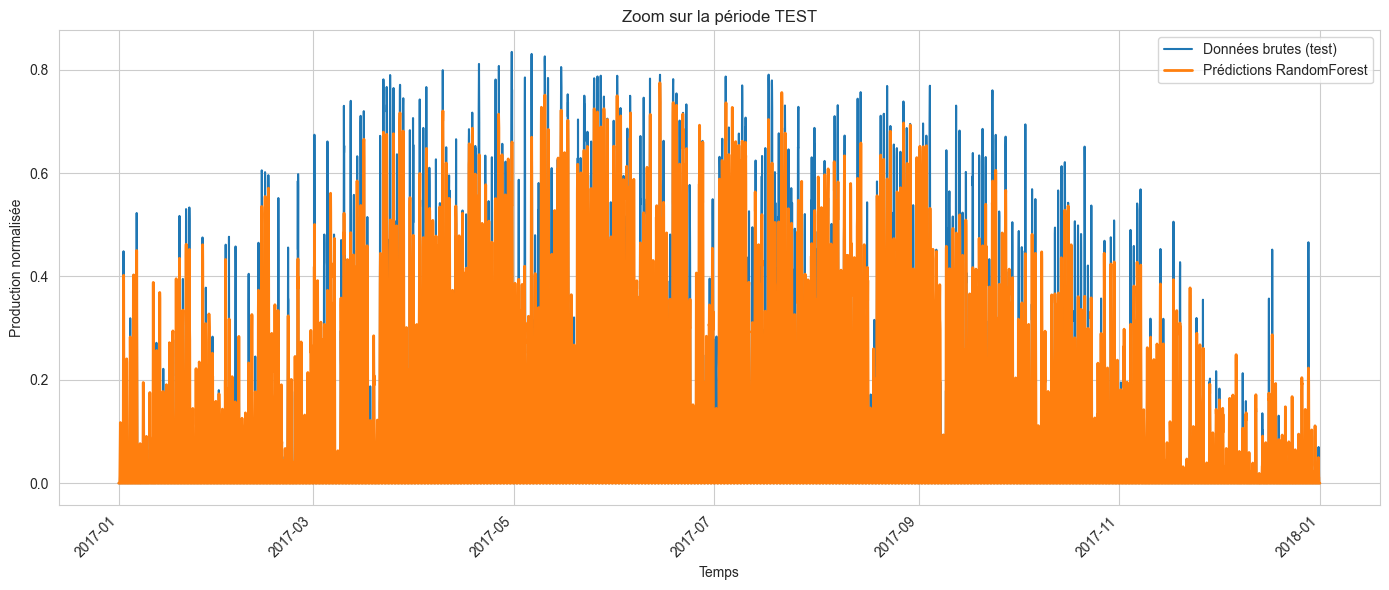

In [8]:
plt.figure(figsize=(14, 6))

plt.plot(
    data['Time'].iloc[-len(y_test):],
    y_test,
    label='Données brutes (test)')

plt.plot(
    data['Time'].iloc[-len(y_pred):],
    y_pred,
    label='Prédictions RandomForest',
    linewidth=2)

plt.xlabel('Temps')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Production normalisée')
plt.title('Zoom sur la période TEST')
plt.legend()
plt.tight_layout()
plt.show()
